# Data Retrieval - Spotify API

<br>

### Imports

In [276]:
import pandas as pd
import numpy as np

from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

import re
import json
import html
import requests
import functools

from warnings import warn
from ipypb import track
from IPython.display import HTML, IFrame, JSON

<br>

### Spotipy Client Initialisation

In [243]:
with open('secrets.json', 'r') as f:
    secrets = json.load(f)
    
client_id = secrets['client_id']
client_secret = secrets['client_secret']

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [284]:
spotify_auth_url = 'https://accounts.spotify.com/authorize'
scopes = ['user-read-private', 'user-modify-playback-state', 'user-read-currently-playing']

query_params = {
    'client_id' : client_id,
    'response_type' : 'code',
    'redirect_uri' : 'http://osuked.com',
    'scope' : ' '.join(scopes)
}

r = requests.get(spotify_auth_url, params=query_params)

r

<Response [200]>

In [285]:
params_str = ''

for k, v in query_params.items():
    params_str += f'{k}={v}&'
    
url = spotify_auth_url + '?' + params_str.replace(' ', '%20')[:-1]

url # need to fix the ampersands, for now remove in url

'https://accounts.spotify.com/authorize?client_id=ed39728cc81445e09e73fbaaac60c0d0&response_type=code&redirect_uri=http://osuked.com&scope=user-read-private%20user-modify-playback-state%20user-read-currently-playing'

In [287]:
## ADD SCOPES FOR USER PLAYBACK

#sp.current_user()

<br>

### Helper Functions

In [2]:
def hide_spines(ax, positions=['top', 'right']):
    """
    Pass a matplotlib axis and list of positions with spines to be removed
    
    args:
        ax:          Matplotlib axis object
        positions:   Python list e.g. ['top', 'bottom']
    """
    assert isinstance(positions, list), 'Position must be passed as a list'
    
    for position in positions:
        ax.spines[position].set_visible(False)
        
def try_accept(exception=np.nan):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            try:
                return func(*args, **kwargs)
            except:
                return exception
        return wrapper
    return decorator

<br>

### Specifying Artist

Here we'll specify the artist we want to get data for, as well as an album that can be used for examples

In [187]:
artist = 'A Tribe Called Quest'
album = 'Beats, Rhymes and Life'

<br>

### Collecting Discography

We start by retrieving a table listing their discography from Wikipedia

In [188]:
wiki_discog_url = f"https://en.wikipedia.org/wiki/{artist.replace(' ', '_')}_discography"

tables = pd.read_html(wiki_discog_url)
df_discog = tables[1]

if isinstance(df_discog.columns, pd.MultiIndex):
    df_discog.columns = df_discog.columns.get_level_values(0)
    
df_discog = df_discog.drop(df_discog.index[df_discog['Title'].str.contains('"—" denotes')])

df_discog.head(2)

,Title,Album details,Peak chart positions,Peak chart positions,Peak chart positions,Peak chart positions,Peak chart positions,Certifications,Unnamed: 8_level_0,Unnamed: 9_level_0,Unnamed: 10_level_0,Unnamed: 11_level_0,Unnamed: 12_level_0,Unnamed: 13_level_0,Unnamed: 14_level_0,Unnamed: 15_level_0,Unnamed: 16_level_0,Unnamed: 17_level_0,Unnamed: 18_level_0,Unnamed: 19_level_0
0,People's Instinctive Travels and the Paths of ...,"Released: April 17, 1990 Label: Jive, RCA Reco...",91,23,—,—,54,RIAA: Gold[13],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,The Low End Theory,"Released: September 24, 1991 Label: Jive Forma...",45,13,—,—,58,RIAA: Platinum[13],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br>

We then clean this up a bit

In [156]:
cols_2_keep = ['Title', 'Album details']

df_discog = df_discog[cols_2_keep]
df_discog.columns = cols_2_keep

s_dt = (df_discog
        ['Album details']
        .str[10:]
        .str.split(' ')
        .apply(lambda l: ' '.join(l[:3]))
       )

df_discog = (df_discog 
             .assign(Date=pd.to_datetime(s_dt))
             .drop(columns='Album details')
            )

df_discog

,Title,Date
0,People's Instinctive Travels and the Paths of ...,1990-04-17
1,The Low End Theory,1991-09-24
2,Midnight Marauders,1993-11-09
3,"Beats, Rhymes and Life",1996-07-30
4,The Love Movement,1998-09-29
5,We Got It from Here... Thank You 4 Your Service,2016-11-11


<br>

### Retrieving Album & Song Data

First we create a spotipy instance and test it out on a single album

In [157]:
@try_accept()
def name_2_album_meta(album, sp, artist=None):
    if artist is not None:
        query = f'{album} {artist}'
    else:
        query = album
        
    result = sp.search(query, type='album') 
    s_first_album = pd.Series(result['albums']['items'][0])
    
    return s_first_albumv 

s_first_album = name_2_album_meta(album, sp, artist)

s_first_album

album_type                                                            album
artists                   [{'external_urls': {'spotify': 'https://open.s...
available_markets         [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...
external_urls             {'spotify': 'https://open.spotify.com/album/0E...
href                      https://api.spotify.com/v1/albums/0EguP4tsJurU...
id                                                   0EguP4tsJurU5I8ocCxdyb
images                    [{'height': 640, 'url': 'https://i.scdn.co/ima...
name                                                   Beats, Rhymes & Life
release_date                                                     1996-07-30
release_date_precision                                                  day
total_tracks                                                             15
type                                                                  album
uri                                    spotify:album:0EguP4tsJurU5I8ocCxdyb
dtype: objec

<br>

We'll add a helper function which will check that the release dates provided by Wikipedia and Spotify are consistent with each other

In [158]:
def check_release_date_consistency(df, s_first_album, album_name, td_val=150, td_units='days'):
    release_date_precision = pd.Timedelta(td_val, unit=td_units)
    
    assert isinstance(s_first_album, pd.Series), 's_first_album must be a Pandas series'
    release_date_sp = pd.to_datetime(s_first_album['release_date'])
    release_date_wiki = df.set_index('Title').loc[album_name, 'Date']

    release_delta = release_date_sp - release_date_wiki
    assert release_delta <= release_date_precision, f"The '{album_name}' release date on Spotify - {release_date_sp.date()}- and Wikipedia - {release_date_wiki.date()} - were inconsistent"
    
check_release_date_consistency(df_discog, s_first_album, album)

<br>

Next we'll extract the relevant data and parse it into a dataframe

In [164]:
%%time

albums = dict()

for album_name in df_discog['Title']:
    try:
        albums[album_name] = name_2_album_meta(album_name, sp, artist)
        check_release_date_consistency(df_discog, albums[album_name], album_name)
    except:
        albums.pop(album_name)
        warn(f'{album_name} could not be processed')

df_albums = pd.DataFrame(albums).T
df_albums.index.name = 'album_name'
df_albums = df_albums[['id', 'release_date', 'total_tracks']]

df_albums

Wall time: 513 ms


,id,release_date,total_tracks
album_name,,,
People's Instinctive Travels and the Paths of Rhythm,3kV0i1qqudjf0PGawJ4jck,1990-04-17,17
The Low End Theory,1p12OAWwudgMqfMzjMvl2a,1991-09-24,14
Midnight Marauders,4v5x3Oo3UjQ9YmF3hRAip5,1993-11-09,14
"Beats, Rhymes and Life",0EguP4tsJurU5I8ocCxdyb,1996-07-30,15
The Love Movement,0FH3WsTCWaDmfpEojJ4sN2,1998-09-29,21
We Got It from Here... Thank You 4 Your Service,3WvQpufOsPzkZvcSuynCf3,2016-11-11,16


<br>

Whilst we've just filtered for the information that will be most important for us later in the analysis, we have still collected all of the other album metadata - e.g. the cover art.

In [166]:
album_art_url = albums[album_name]['images'][0]['url']

Image(url=album_art_url, height=250, width=250)

<br>

The next step in the process is to retrieve information about the album songs

In [167]:
album_id = albums[album_name]['id']
album_uri = f'spotify:album:{album_id}'

album_tracks = sp.album_tracks(album_uri)
num_tracks = len(album_tracks['items'])

example_track = album_tracks['items'][-1]
s_example_track = pd.Series(example_track)

print(f"There are {num_tracks} tracks on '{album_name}'\n\nExample track data:")
s_example_track

There are 16 tracks on 'We Got It from Here... Thank You 4 Your Service'

Example track data:


artists              [{'external_urls': {'spotify': 'https://open.s...
available_markets    [AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...
disc_number                                                          2
duration_ms                                                     322233
explicit                                                          True
external_urls        {'spotify': 'https://open.spotify.com/track/0B...
href                 https://api.spotify.com/v1/tracks/0BXZq7Np5y2k...
id                                              0BXZq7Np5y2kWNyH6zbrAc
is_local                                                         False
name                                                        The Donald
preview_url          https://p.scdn.co/mp3-preview/c9004dcbccd6c877...
track_number                                                         8
type                                                             track
uri                               spotify:track:0BXZq7Np5y2kWNyH6zbrAc
dtype:

<br>

Thanks to the IPython team we can listen to an audio sample without leaving a notebook

In [168]:
example_track_sample = f"{example_track['preview_url']}.mp3"

ipd.Audio(example_track_sample)

<br>

We can create a dataframe from the most relevant columns

In [169]:
df_album_songs = pd.DataFrame(album_tracks['items'])[['id', 'name', 'preview_url', 'track_number']]

df_album_songs

,id,name,preview_url,track_number
0,203xmWRHAyqwW6AkGkhhVM,The Space Program,https://p.scdn.co/mp3-preview/1d89cf2c6a86318a...,1
1,3wUX7HpXS382s1DHTRouVk,We The People....,https://p.scdn.co/mp3-preview/33d620e9e6fc1896...,2
2,3z40poMPmOkS6799tbXGKz,Whateva Will Be,https://p.scdn.co/mp3-preview/371c54f2ef2fbf25...,3
3,5OzOQRssjhxaBj0xd78Z2w,Solid Wall of Sound,https://p.scdn.co/mp3-preview/ccce28faaf46d7f9...,4
4,2Pp3QD3thPnk2kCxmu2MHK,Dis Generation,https://p.scdn.co/mp3-preview/9a3db73fb0ce1bd5...,5
5,3awU4bBZTmisGbeJJ4xb3c,Kids...,https://p.scdn.co/mp3-preview/06e7d8b784d8da8b...,6
6,366xKgsZ8bFjIhG7JjfCkj,Melatonin,https://p.scdn.co/mp3-preview/486c3ea3bdda7918...,7
7,1WvGWCDuj0dfRpuBuYecXp,Enough!!,https://p.scdn.co/mp3-preview/e36b57f70b491ef7...,8
8,0Zo2Sc9OLyAql82M85GI4J,Mobius,https://p.scdn.co/mp3-preview/bbd96d36c5c8aaa6...,1
9,1qju0WsEHiDZoOBBDp8aAk,Black Spasmodic,https://p.scdn.co/mp3-preview/fbff28be66f1c9c5...,2


<br>

We'll now repeat the steps of retrieving the song information and filtering for the relevant columns, the album name will then be added before combining the dataframes into a single object.

In [171]:
%%time

df_songs = pd.DataFrame()

album_2_release_date = (df_albums
                        ['release_date']
                        .apply(lambda dt: pd.to_datetime(dt).date())
                        .to_dict()
                       )

for album_name in track(df_albums.index):
    album_id = df_albums.loc[album_name, 'id']
    album_uri = f'spotify:album:{album_id}'
    
    album_tracks = sp.album_tracks(album_uri)
    
    df_album_songs = pd.DataFrame(album_tracks['items'])[['id', 'name', 'preview_url', 'track_number']]
    
    df_album_songs['album'] = album_name
    df_album_songs['album_release'] = album_2_release_date[album_name]
    
    df_songs = df_songs.append(df_album_songs)
    
df_songs.head()

 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.06s/it]

Wall time: 378 ms


,id,name,preview_url,track_number,album,album_release
0,2Qoui6iAiX1VVV21yWayBD,Push It Along,https://p.scdn.co/mp3-preview/58d38b662e07e969...,1,People's Instinctive Travels and the Paths of ...,1990-04-17
1,7EhEPcPa60LlvGuG9R1DOx,Luck of Lucien,https://p.scdn.co/mp3-preview/b704ea6cbb92aa70...,2,People's Instinctive Travels and the Paths of ...,1990-04-17
2,5MNch1DaIp20fiHKmLHcp0,After Hours,https://p.scdn.co/mp3-preview/e7b19f0aee6bfc97...,3,People's Instinctive Travels and the Paths of ...,1990-04-17
3,3trSZ6JhgNpDhTfRvge4go,Footprints,https://p.scdn.co/mp3-preview/c0bfdf02baddcbc4...,4,People's Instinctive Travels and the Paths of ...,1990-04-17
4,15Xdlu0QaiEy3YFTf4xpUA,I Left My Wallet in El Segundo,https://p.scdn.co/mp3-preview/057d7643f457dc11...,5,People's Instinctive Travels and the Paths of ...,1990-04-17


<br>

We can now request the features that Spotify derives for every song

In [204]:
features_2_keep = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 
                   'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'] #, 'mode', 'time_signature']

example_track_uri = f"spotify:track:{s_example_track['id']}"
s_example_track_analysis = pd.Series(sp.audio_features(example_track_uri)[0])[features_2_keep]

s_example_track_analysis

danceability            0.74
energy                   0.6
key                        1
loudness              -8.443
speechiness            0.319
acousticness           0.606
instrumentalness    0.000752
liveness               0.137
valence                0.637
tempo                 96.542
duration_ms           322234
dtype: object

<br>

We'll do this for every song

In [205]:
df_songs_analysis = pd.DataFrame()

for track_idx, track_data in track(df_songs.iterrows(), total=df_songs.shape[0]):
    example_track_uri = f"spotify:track:{track_data['id']}"
    
    s_example_track_analysis = pd.Series(sp.audio_features(example_track_uri)[0])[features_2_keep]
    df_songs_analysis[track_idx] = s_example_track_analysis
    
df_songs[df_songs_analysis.index] = df_songs_analysis.T

df_songs.head(2)

 [████████████████████████████████████████████████████████████] 97/97 [00:05<00:00, 0.05s/it]

,id,name,preview_url,track_number,album,album_release,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2Qoui6iAiX1VVV21yWayBD,Push It Along,https://p.scdn.co/mp3-preview/58d38b662e07e969...,1,People's Instinctive Travels and the Paths of ...,1990-04-17,0.612,0.705,1,-5.898,1,0.352,0.427,0,0.658,0.533,101.876,341040,4
1,7EhEPcPa60LlvGuG9R1DOx,Luck of Lucien,https://p.scdn.co/mp3-preview/b704ea6cbb92aa70...,2,People's Instinctive Travels and the Paths of ...,1990-04-17,0.71,0.805,1,-5.471,1,0.0637,0.00909,0,0.141,0.897,92.601,172013,4


<br>

We can already start to explore some patterns such as how/if an artist varies over time for a particular Spotify feature

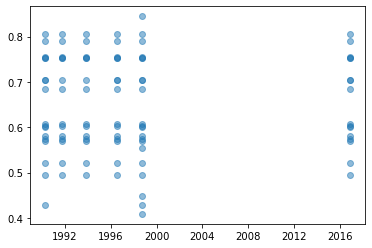

In [206]:
plt.scatter(df_songs['album_release'], df_songs['energy'], alpha=0.5)

<br>

We can also use Seaborn to create density plots for each feature

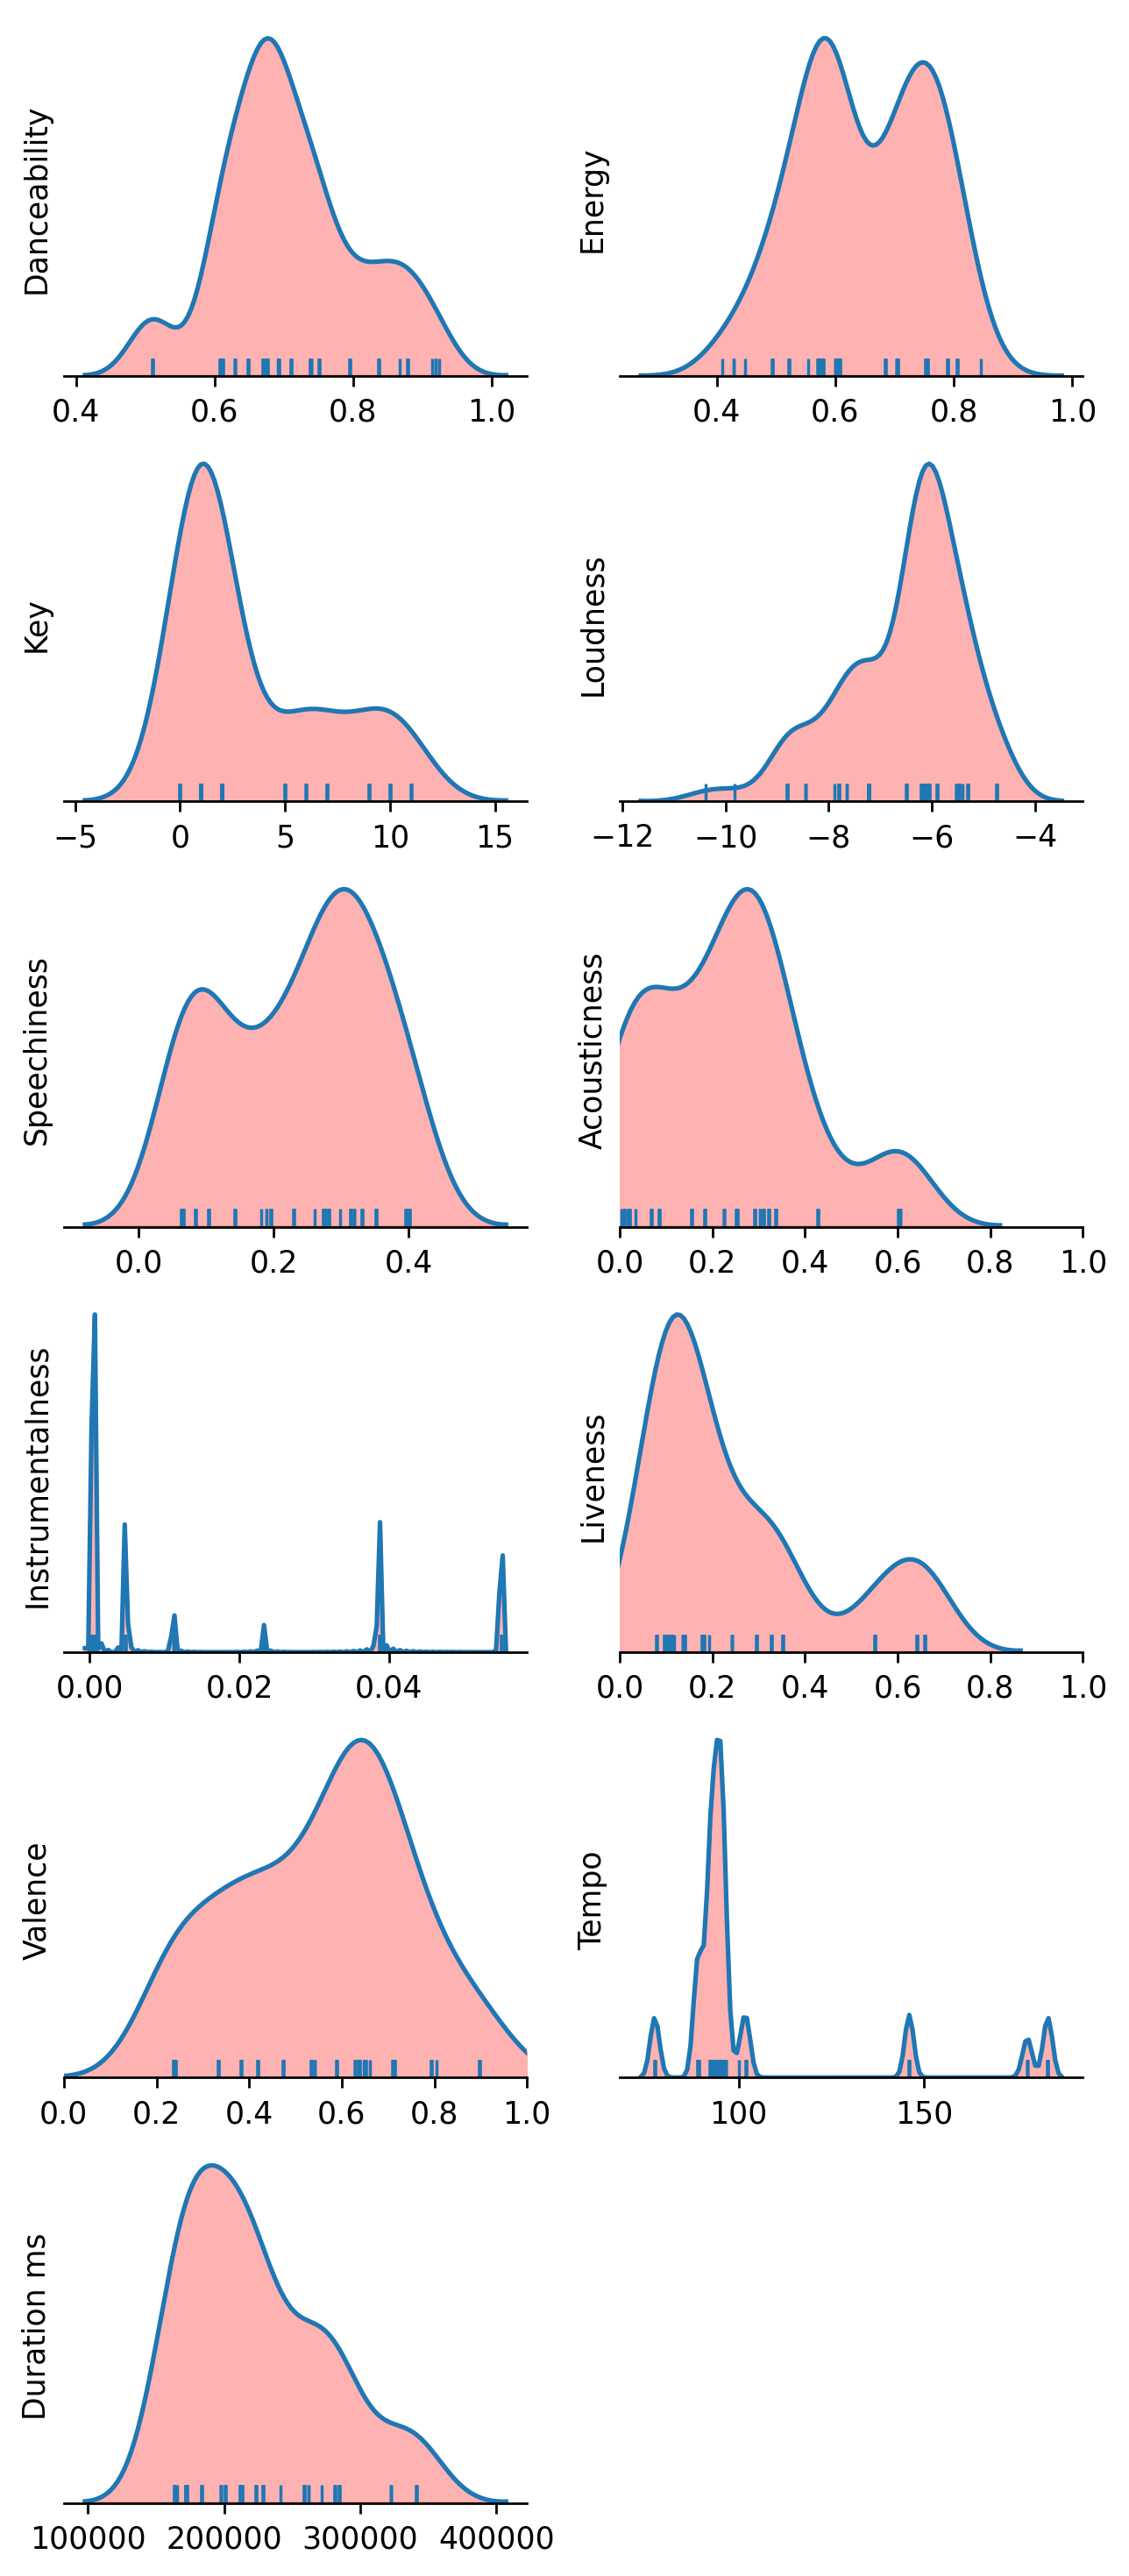

In [212]:
nrows = int(np.ceil(len(features_2_keep)/2))

fig, axs = plt.subplots(dpi=250, nrows=nrows, ncols=2, figsize=(6, 15))
axs = axs.flatten()

for ax_idx, feature in enumerate(features_2_keep):
    s_feature = df_songs[feature]
    ax = axs[ax_idx]
    
    # plotting
    sns.distplot(s_feature, hist=False, ax=ax)
    sns.rugplot(s_feature, height=0.05, axis='x', ax=ax)
    
    # filling the density plot
    l = ax.lines[0]
    KDE_x = l.get_xydata()[:,0]
    KDE_y = l.get_xydata()[:,1]
    ax.fill_between(KDE_x, KDE_y, color='red', alpha=0.3)

    # handling aesthetics
    hide_spines(ax, positions=['top', 'left', 'right'])
    
    # y axis
    ax.set_ylim(0)
    ax.set_yticks([])
    ax.set_ylabel(f"{feature.replace('_', ' ').capitalize()}")

    ## x axis
    ax.set_xlabel('')
    if s_feature.min()>0 and s_feature.max()<1 and (s_feature.max() - s_feature.min()) > 0.5:
        ax.set_xlim(0, 1)
        
if nrows != len(features_2_keep)/2:
    hide_spines(axs[-1], positions=['top', 'bottom', 'left', 'right'])
    axs[-1].set_xticks([])
    axs[-1].set_yticks([])

In [ ]:
## Use dataset as a storage system for the metadata
## Try and download the new GIF images that spotify is using

## grab tour dates and locations - e.g. from https://www.songkick.com/artists/400904-pink-floyd/gigography?page=2
## see if a country's popularity correlates with the number of tour stops